## Downloading and processing AHNx

developed by Teije van der Horst

In this notebook, we will automatically download the 'Actueel Hoogtebestand nederland' (AHN). The example is set for the AHN2 5m which is easier on the internet connection and processing steps.

For this script, we make use of the feedparser package **unless you have Python 3.7 in which case you have to install requests** 

feedparser can be installed through the command line using:

```console
$ pip install feedparser
```

and requests (if not installed yet) through

```console
$ conda install -c conda-forge requests
```

In [1]:
import os
from shutil import copyfileobj
import urllib
import requests

## AHN2
First we need to specify which version of the AHN we want to download. There are some choices available (see https://www.pdok.nl/downloads?articleid=1948857#1066961ba7c918cc4245e7b4f66efd7f for a detailed explanation)

- AHN2 0.5 meter maaiveld raster, opgevuld: 
http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_05m_int.xml

- AHN2 0.5 meter maaiveld raster, niet opgevuld: 
http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_05m_non.xml

- AHN2 0.5 meter ruw raster:
http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_05m_ruw.xml

- AHN2 5 meter maaiveld raster:
http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_5m.xml

We will use the latter product in this example.

## AHN3
or AHN3, it seems that the RSS feed (xml link) is not available (anymore/yet). For this, it is possible to construct a download link using a recipe:
1. base_url = `'https://geodata.nationaalgeoregister.nl/ahn3/extract/ahn3_'`
2. raster_type = 
    - `'05m_dsm/R_'` (0,5 meter raster dsm = oppervlakte metingen)
    - `'05m_dtm/M_'` (0,5 meter raster dtm = maaiveld)
    - `'5m_dsm/R5_'` (5 meter raster dsm = oppervlakte metingen)
    - `'5m_dtm/M5_'` (5 meter raster dtm = maaiveld)
    - `'laz/C_'` (puntenwolk)
3. mapindex = `'38FZ2'` (for example) **NOTE: the 'ahn_units.shp' bladindex is used for AHN3 0.5 and 5 m and indices need to be converted to upper case**
4. extension = 
    - `'.ZIP'`
    - `'.LAZ'`

`url = base_url + raster_type + mapindex + extension`
https://geodata.nationaalgeoregister.nl/ahn3/extract/ahn3_laz/C_38GN2.LAZ

In [ ]:
# base_url = 'https://geodata.nationaalgeoregister.nl/ahn3/extract/ahn3_'
# raster_type = '05m_dsm/R_'
# mapindex = '31hn2'.upper()
# extension = '.ZIP'
# url = base_url + raster_type + mapindex + extension
# print(url)  
# should yield: https://geodata.nationaalgeoregister.nl/ahn3/extract/ahn3_05m_dsm/R_31HN2.ZIP

In [2]:
ahn2rss = 'http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_5m.xml'

Let's first find a way to download a file. For this we are going to use the `requests` package which a very nice one and which is available on all python versions (officially supports Python 2.7 & 3.4–3.7) and operating systems (which is not the case for the buitin scripts for downloading that have changed slightly over time)

In [3]:
r = requests.get(ahn2rss)
print('Statuscode 200 indicates successful request')
print('\tstatus_code = {}\n'.format(r.status_code))
print(r.headers)


Statuscode 200 indicates successful request
	status_code = 200

{'Date': 'Tue, 15 Jan 2019 18:33:39 GMT', 'Content-Type': 'text/xml', 'Content-Length': '1157246', 'X-Cnection': 'close, close', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Methods': 'POST, GET, OPTIONS, HEAD', 'Access-Control-Max-Age': '1000', 'Access-Control-Allow-Headers': 'SOAPAction,X-Requested-With,Content-Type,Origin,Authorization,Accept'}


with the request instance `r`, we can download the content that we have requested. Since we will be using this more often, it is nice to have this operation in a function. For this we can use the `iter_content` method which chunks up the requested file into managable pieces (given that streaming is supported for this request).

In [4]:
def download(url, out_path, fn):
    r = requests.get(url, verify=True, stream=True)
    if r.status_code == 200:  # 200 means successfull get request
        if not os.path.isdir(out_path): 
            os.mkdir(out_path)  # This works only if one folder layer needs to be created
        fn = os.path.join(out_path, fn)  # combine path and filename, this works on all operating systems
        with open(fn, 'wb') as f:  # Open a file and close after the while statement
            for chunk in r.iter_content(1024*1024):  # read 1 MB at a time
                f.write(chunk)
        return fn
    else:
        raise RuntimeWarning('Could not download from {}\n status_code = {}'.format(url, r.status_code))
        return r.status_code
    # No return statement necessary

<div class="note"></div>       
**NOTE**:  For Python 3.7, the feedparser breaks, so we need another method to get the desired output. We parse the RSS xml using requests, and then we read that using the xml package

In [5]:
import sys
tiles = {}
if sys.version.startswith('3.7'):
    
    xml = download(ahn2rss, out_path='AHN_XML', fn='ahn2_5m.xml')
    
    import xml.etree.ElementTree as ET
    
    tree = ET.parse(xml)
    root = tree.getroot()
    
    prefix = '{http://www.w3.org/2005/Atom}'  # parsing has prefix for some reason?
    for entry in root.findall(prefix+'entry'):
        tile_id = entry.find(prefix+'id').text.split('.tif.zip')[0].split('_')[-1]  # Change this line for 0.5 meter
        tile_link = entry.find(prefix+'link').attrib['href']
        tiles[tile_id] = tile_link
            
else:
    import feedparser
    d = feedparser.parse(ahn2rss)
    entries = d['entries']
    links = [e['links'][0]['href'].encode('ascii') for e in entries]
    for link in links:
        tiles[link.split('/')[-1]] = link 
    

If all went well, you should now have a Python dictionary with all available tiles and the adress to get them from

In [6]:
for key in list(tiles.keys())[0:5]:
    print("Tile '{}' can be found through {}".format(key, tiles[key]))
print('...\nAnd so on ...')

Tile '01cz1' can be found through http://geodata.nationaalgeoregister.nl/ahn2/extract/ahn2_5m/ahn2_5_01cz1.tif.zip
Tile '01cz2' can be found through http://geodata.nationaalgeoregister.nl/ahn2/extract/ahn2_5m/ahn2_5_01cz2.tif.zip
Tile '01dz1' can be found through http://geodata.nationaalgeoregister.nl/ahn2/extract/ahn2_5m/ahn2_5_01dz1.tif.zip
Tile '01dz2' can be found through http://geodata.nationaalgeoregister.nl/ahn2/extract/ahn2_5m/ahn2_5_01dz2.tif.zip
Tile '01gn1' can be found through http://geodata.nationaalgeoregister.nl/ahn2/extract/ahn2_5m/ahn2_5_01gn1.tif.zip
...
And so on ...


Now we have to filter which of those to download by means of the 'bladindex' shapefiles (see http://www.ahn.nl/common-nlm/open-data.html). These can be found at the following two adresses for the **main units (5m products)**:
- http://www.ahn.nl/binaries/content/assets/ahn-nl/downloads/ahn_units.zip

and also for the **sub units (0.5 m products)**
- http://www.ahn.nl/binaries/content/assets/ahn-nl/downloads/ahn_subunits.zip

Let's download them

In [7]:
bladindex1 = 'http://www.ahn.nl/binaries/content/assets/ahn-nl/downloads/ahn_units.zip'
ahn_units = download(bladindex1, 'bladindex', 'ahn_units.zip')
bladindex2 = 'http://www.ahn.nl/binaries/content/assets/ahn-nl/downloads/ahn_subunits.zip'
ahn_subunits = download(bladindex2, 'bladindex', 'ahn_subunits.zip')

We can't access the zipfile directly, so we have to unzip it. Let's make a function for that so we don't have to do this more often

In [8]:
from zipfile import ZipFile
def unzip(zipfile, out_path, delete=True):
    if not os.path.isdir(out_path): 
            os.mkdir(out_path)
    with ZipFile(zipfile, 'r') as zipobj:
        zipobj.extractall(out_path)
    if delete:
        os.remove(zipfile)
    # No return statement necessary

An ofcourse, now we use the function to extract the zipfile we just downloaded, next to the zipfile

In [9]:
unzip(ahn_units, 'bladindex', delete=False)
unzip(ahn_subunits, 'bladindex', delete=False)

Now we are ready to filter the required tiles (if necessary) by using for instance another shapefile to intersect the 'bladindex' with. There are various ways of doing this, some of which are explained in:
https://gis.stackexchange.com/questions/178765/intersecting-two-shapefiles-from-python-or-command-line

This method uses geopandas

In [11]:
blad_shp = ahn_units.split('.zip')[0] + '.shp'  # Gets the shapefile filename
isct_shp = os.path.join('shapefile', 'ahn_intersect.shp')
print(blad_shp)
print(isct_shp)

bladindex\ahn_units.shp
shapefile\ahn_intersect.shp


In [12]:
import geopandas as gpd
g1 = gpd.GeoDataFrame.from_file(blad_shp)
g2 = gpd.GeoDataFrame.from_file(isct_shp)

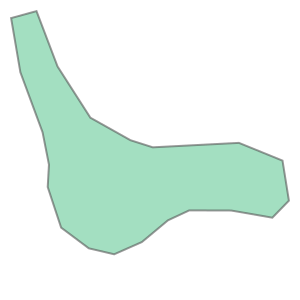

In [13]:
geo2 = next(g2.itertuples()).geometry
geo2

In [14]:
selection = []
for blad in g1.itertuples():
    if geo2.intersects(blad.geometry):
        selection.append(blad.UNIT)
        print('Adding "{}" to download list'.format(selection[-1]))

Adding "31hn2" to download list
Adding "32cn1" to download list
Adding "31hz2" to download list
Adding "32cz1" to download list


In [15]:
selection

['31hn2', '32cn1', '31hz2', '32cz1']

In [16]:
# Filter the bladindex shapefiles using a costum made shapefile
selected_tiles = {key:tiles[key] for key in selection}
print(selected_tiles)

# Uncomment the next line to get tile 600-604 from the tiles dict as an example
# selected_tiles = {key:value for key, value in zip(list(tiles.keys())[600:605], list(tiles.values())[600:605])}

{'31hn2': 'http://geodata.nationaalgeoregister.nl/ahn2/extract/ahn2_5m/ahn2_5_31hn2.tif.zip', '32cn1': 'http://geodata.nationaalgeoregister.nl/ahn2/extract/ahn2_5m/ahn2_5_32cn1.tif.zip', '31hz2': 'http://geodata.nationaalgeoregister.nl/ahn2/extract/ahn2_5m/ahn2_5_31hz2.tif.zip', '32cz1': 'http://geodata.nationaalgeoregister.nl/ahn2/extract/ahn2_5m/ahn2_5_32cz1.tif.zip'}


The filtered dictionary is ready for download now. Let's create an output folder to download our tiff files to

In [17]:
zipdir = 'AHN2_5m_zip'
if not os.path.isdir(zipdir):  # Always check if a folder was already created first
    os.mkdir(zipdir)

Download the actual files, if they don't exist yet

In [18]:
downloaded = []
for tile in selected_tiles.keys():
    fn = selected_tiles[tile].split('/')[-1]
    ziptile = os.path.join(zipdir, fn)
    if os.path.exists(ziptile) and os.path.getsize(ziptile) > 0:
        print('File "{}" already downloaded, skipping'.format(ziptile))
        downloaded.append(ziptile)
    else:
        print('Downloading to: {}'.format(ziptile))
        output = download(selected_tiles[tile], zipdir, fn)
        downloaded.append(output)
print('Done')

Done


Now unzip these files into a new folder

In [19]:
tifdir = 'AHN2_5m_tif'
for zipfile in downloaded:
    unzip(zipfile, tifdir, delete=False)

Now that we have downloaded these files already, we can combine them into one file, WITHOUT loading the data into memory. For this we use the incredible Geospatial Data Abstraction Library ([gdal](https://gdal.org/)) package. 

If you don't have gdal yet, install it in your conda (!) environment using
```console
$ conda install -c conda-forge gdal
```

Notice that it is loaded with the command: 
```python
>>> from osgeo import gdal```

gdal is what drives QGIS in the background, and is a very powerful and well maintained library that supports nearly all of the common gridded dataset IO.

In [20]:
from osgeo import gdal

Now we are going to make a virtual raster dataset, also known as a [vrt](https://gdal.org/gdal_vrttut.html) which is a very useful way of combining rasters without having to compute a thing. We need this vrt for further calculations, but even a QGIS browser supports loading this vrt (try it)

In [21]:
import glob
tifs = glob.glob(tifdir + os.path.sep + '*.tif')  # extract all tif files
ds = gdal.BuildVRT('.\AHN2_5m.vrt', tifs)  # build a vrt file
ds.FlushCache()

Finally, we want to cut out a certain area from the AHN using the shapefile that we used to intersect with the bladindex. For this, we can still use gdal. The gdalwarp can be used to convert a dataset to another using a cutline (and a ton of other options as well). For now we stick to the cutline option


In [22]:
output_raster = 'AHN2_5m_cut.tif'
clip = gdal.Warp(output_raster, ds,
                 options=gdal.WarpOptions(format='GTiff',
                                          dstSRS=ds.GetProjectionRef(),
                                          cutlineDSName=isct_shp,
                                          cropToCutline=True,
                                          creationOptions= [ 'COMPRESS=LZW', 'TILED=YES', 'BIGTIFF=IF_SAFER']))

## And we're done

If you are working with *puntenwolken*, then you are downloading LAZ files. These files are very large and might not fit into memory when reading them. Have a look at some Python packages that are created for working with LIDAR LAZ files (advanced):
- [pydal](https://pdal.io/)
- [lazpy](https://pypi.org/project/laspy/)
- [PyLidar](http://www.pylidar.org/en/latest/)
- [~~liblas~~](https://liblas.org/)